In [2]:
from minio import Minio
import s3fs
import os
import matplotlib.pyplot as plt
import xarray as xr

### Minio
* Minio is a storage server which is usually used to store large datasets. The data is stored inside "buckets" which is split across different disks. side note - bucket name can't have caps.


* You can view/download files from the server by using a web browser or connecting to the server using a python script. Only works if you're connected to IISER network lol.


* To connect using web browser use the url - http://192.168.1.237:9000
  * login id/username - d0d250b2541ac33f4660
  * login password - 2fb32d964768bc94a3c0


* Python script examples are below. Two ways to connect, either using s3fs or minio. Choice depends on what you want to do, sometimes one might work while the other won't.

### Information on data location
* Base model 1000 year run 
  * original data - abel-long-run/long_run_data
  * regridded data - abel-long-run/Regridded_data


In [ ]:
#to create new bucket

client = Minio(
    "192.168.1.237:9000",
    access_key="d0d250b2541ac33f4660",
    secret_key="2fb32d964768bc94a3c0",
    secure=False
)
bucket_name = "abel-long-run"
if not client.bucket_exists(bucket_name):
    client.make_bucket(bucket_name)

In [5]:
#to view existing buckets

fs = s3fs.S3FileSystem(
    key="d0d250b2541ac33f4660",
    secret="2fb32d964768bc94a3c0",
    client_kwargs={"endpoint_url": "http://192.168.1.237:9000"}
)

print(fs.ls('')) 

['abel-long-run', 'climt-long-runs', 'era5', 'monsoon-mission-data', 'repo2', 'zarr']


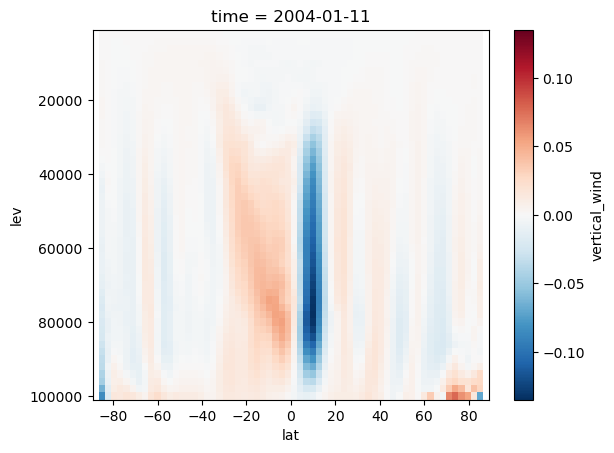

In [59]:
#to read data

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "http://192.168.1.237:9000"
    },
    key="d0d250b2541ac33f4660",
    secret="2fb32d964768bc94a3c0"
)

# Path inside the bucket to your Zarr store
zarr_path = "abel-long-run/Regridded_data/run1/year1/"


ds = xr.open_zarr(fs.get_mapper(zarr_path))
#ds.air_pressure[1].mean(dim='lon').plot()
ds['vertical_wind'][1].mean(dim='lon').plot()
plt.gca().invert_yaxis()

In [ ]:
#to delete stuff, S3fs doesnt work for some reason.

client = Minio(
    "192.168.1.237:9000",
    access_key="d0d250b2541ac33f4660",
    secret_key="2fb32d964768bc94a3c0",
    secure=False
)

bucket = "abel-long-run"
#file_path = "Regidded_data/run1"

objects = client.list_objects(bucket, prefix="long_run", recursive=True)
for obj in objects:
    client.remove_object(bucket, obj.object_name)

In [57]:
#to check files in the bucket

# connect
client = Minio(
    "192.168.1.237:9000",
    access_key="d0d250b2541ac33f4660",
    secret_key="2fb32d964768bc94a3c0",
    secure=False
)

bucket = "abel-long-run"
prefix = "Regridded_data/common/"   # "folder" you want to check
for obj in client.list_objects(bucket, prefix=prefix, recursive=False):
    print(obj.object_name)

Regridded_data/common/.zattrs
Regridded_data/common/.zgroup
Regridded_data/common/area_type/
Regridded_data/common/latitude/
Regridded_data/common/longitude/


In [61]:
fs.ls('abel-long-run')

['abel-long-run/Regridded_data', 'abel-long-run/long_run_data']

In [ ]:
#to check folder/file size in minio bucket
#probably will take a lot of time for folders with multiple files
#easier to just login using the web browser.

from minio import Minio

# connect
client = Minio(
    "192.168.1.237:9000",
    access_key="d0d250b2541ac33f4660",
    secret_key="2fb32d964768bc94a3c0",
    secure=False
)

bucket = "abel-long-run"
prefix = "Regridded_data/run1/year1/"   # "folder" you want to check

# sum up object sizes
total_size = 0
for obj in client.list_objects(bucket, prefix=prefix, recursive=True):
    total_size += obj.size
    print(obj.object_name, obj.size)

# convert to human-readable
def sizeof_fmt(num, suffix="B"):
    for unit in ["","K","M","G","T","P","E","Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

print(f"Total size of {bucket}/{prefix} = {sizeof_fmt(total_size)}")


In [ ]:
#to upload stuff

#years = [f'year{i}' for i in range(1,21)]
#runs = runs = [f'run{i}' for i in range(1,51)]
years = ['year1']
runs = ['run1']
#As = [f'A{i}' for i in range(1,51)]

for run in runs:
    for year in years:
        
        local_dir = f"/home/scratch/Abel_data/long_run2/{run}/{year}" #local host
        remote_prefix = f"long_run_data/{run}/{year}" #inside minio

        for root, dirs, files in os.walk(local_dir):
            for filename in files:
                local_file = os.path.join(root, filename)

                # preserve relative path inside the bucket
                rel_path = os.path.relpath(local_file, local_dir)
                object_name = os.path.join(remote_prefix, rel_path).replace("\\", "/")

                client.fput_object(bucket, object_name, local_file)
                print(f"Uploaded {local_file} -> {bucket}/{object_name}")